In [3]:
import numpy as np
import sys
sys.path.append("/users/tom/git/neon_blink_detection/")

from training.video_loader import video_loader
from src.helper import OfParams
from pathlib import Path
from src.neon_blink_detector import detect_blinks
import typing as T
from helper import OfParams, PPParams, AugParams
from post_processing import post_process
from xgboost import XGBClassifier
from pathlib import Path
import joblib
from features_calculator import calculate_optical_flow, concatenate_features, create_grids
from utils import resize_images, rotate_images

video_path = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()

iclip = 0

clip_names = [
    "2023-03-01_09-59-07-2ea49126",  # kai bike
    "2023-01-27_15-59-54-49a115d5",  # tom computer
    "2023-02-01_11-45-11-7621531e",  # kai computer
    "2023-01-27_16-10-14-a2a8cbe1",  # ryan discussing
    "2023-01-27_16-15-26-57802f75",  # tom walking
    "2023-01-27_16-24-04-eb4305b1",  # kai walking
    "2023-01-27_16-31-52-5f743ed0",  # moritz snowboarding
    "padel_tennis_neon_01-b922b245",  # mgg padel
    "padel_tennis_neon_03-2ded8f56",  # mgg partner padel
]


def get_params() -> T.Tuple[OfParams, PPParams]:
    """Get optical flow parameters and post processing parameters."""

    of_params = OfParams(5, 7, False, (64, 64), 4, 7, 15, 3)
    pp_params = PPParams(
        max_gap_duration_s=0.03,
        short_event_min_len_s=0.1,
        smooth_window=11,
        proba_onset_threshold=0.25,
        proba_offset_threshold=0.25,
    )
    
    aug_params = AugParams()
    return of_params, pp_params

def get_classifier(clf_path: Path) -> XGBClassifier:
    """Get classifier with weights."""

    return joblib.load(str(clf_path))

of_params, pp_params = get_params()
aug_params = AugParams()
of_params.n_layers = 5
of_params.layer_interval = 7
of_params.grid_size = 4
of_params.window_size = 15

clf = get_classifier("/users/tom/git/neon_blink_detection/weights/xgb.sav")

rec = video_loader(of_params, aug_params)
ts, images_left, images_right = rec._get_frames_pyav(clip_names[iclip], convert_to_gray=True)

times = (ts - ts[0]) / 1e9
# times = np.arange(0, len(ts)) / 200.0
blink_df = rec._load_gt_labels(clip_names[iclip])

grid = create_grids(of_params.img_shape, of_params.grid_size+2, full_grid=False)
images_left, images_right = resize_images(images_left, images_right, of_params.img_shape)

feature_array, _ = calculate_optical_flow(of_params, images_left, images_right, grids=grid)

features = concatenate_features(feature_array, of_params)
proba = clf.predict_proba(features)
blink_events = post_process(ts, proba, pp_params)

from src.utils import resize_images

left_images, right_images = resize_images(
    images_left, images_right, img_shape=(64, 64)
)

blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
blink_off_idx = np.where(np.isin(ts, blink_ts))[0]


img_left = np.concatenate([left_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])
img_right = np.concatenate([right_images[blink_on_idx[x]: blink_off_idx[x], :, :] for x in range(len(blink_on_idx))])

predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])

predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

def compute_iou(event1, event2):
    start1, end1 = event1
    start2, end2 = event2
    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)
    intersection_length = max(0, intersection_end - intersection_start)
    
    union_start = min(start1, start2)
    union_end = max(end1, end2)
    union_length = union_end - union_start

    return intersection_length / union_length

def compute_multiple_iou(ground_truth_events, predicted_events, iou_threshold=0.2):
    ground_truth_indices = set(range(len(ground_truth_events)))
    predicted_indices = set(range(len(predicted_events)))
    iou_results = []
    true_positives = []

    for gt_index, gt_event in enumerate(ground_truth_events):
        for pred_index, pred_event in enumerate(predicted_events):
            iou = compute_iou(gt_event, pred_event)
            if iou > iou_threshold:
                iou_results.append((gt_index, pred_index, iou))
                true_positives.append((pred_index, predicted_events[pred_index]))
                if gt_index in ground_truth_indices:
                    ground_truth_indices.remove(gt_index)
                if pred_index in predicted_indices:
                    predicted_indices.remove(pred_index)

    false_negatives = [(i, ground_truth_events[i]) for i in ground_truth_indices]
    false_positives = [(i, predicted_events[i]) for i in predicted_indices]

    return iou_results, true_positives, false_negatives, false_positives


pred = [(predicted_blink_on[x], predicted_blink_off[x]) for x in range(len(predicted_blink_on))]

gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

iou_results, true_positives, false_negatives, false_positives = compute_multiple_iou(gt, pred, iou_threshold=0.2)



KeyError: 0

AttributeError: 'XGBModel' object has no attribute 'callbacks'

AttributeError: 'XGBModel' object has no attribute 'callbacks'

AttributeError: 'XGBModel' object has no attribute 'callbacks'

**CREATE VIDEO OF FALSE POSITIVES**

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML


for i in range(len(false_positives)):

    fig, axs = plt.subplots(2, 2)

    video_left = images_left[false_positives[i][1][0]:false_positives[i][1][1],:,:]
    video_right = images_right[false_positives[i][1][0]:false_positives[i][1][1],:,:]

    fig.set_size_inches(8, 6)
    im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
    im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
    axs[0, 0].axis("off")
    axs[0, 1].axis("off")

    plt.close() # this is required to not display the generated image

    # plot proba output of the classifier for the false positive event
    axs[1, 0].plot(proba[false_positives[i][1][0]:false_positives[i][1][1], :])
    axs[1, 0].set_xlabel("Frame")
    axs[1, 0].set_ylabel("Probability")
    # legend
    axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

    axs[1, 1].axis("off")

    def init():
        im0.set_data(video_left[0,:,:])
        im1.set_data(video_right[0,:,:])

    def animate(frame):
        im0.set_data(video_left[frame,:,:])
        im1.set_data(video_right[frame,:,:])

        return im0, im1

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

    anim.save('/users/tom/blink_videos/FP%d_rec%s.mp4' %(i, clip_names[iclip]), extra_args=['-vcodec', 'libx264'])

    HTML(anim.to_html5_video())

**CREATE VIDEO OF FALSE NEGTIVES**

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML


for i in range(len(false_negatives)):

    fig, axs = plt.subplots(2, 2)

    video_left = images_left[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]
    video_right = images_right[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]

    fig.set_size_inches(8, 6)
    im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
    im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
    axs[0, 0].axis("off")
    axs[0, 1].axis("off")

    plt.close() # this is required to not display the generated image

    # plot proba output of the classifier for the false positive event
    axs[1, 0].plot(proba[false_negatives[i][1][0]:false_negatives[i][1][1], :])
    axs[1, 0].set_xlabel("Frame")
    axs[1, 0].set_ylabel("Probability")
    # legend
    axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

    axs[1, 1].axis("off")

    def init():
        im0.set_data(video_left[0,:,:])
        im1.set_data(video_right[0,:,:])

    def animate(frame):
        im0.set_data(video_left[frame,:,:])
        im1.set_data(video_right[frame,:,:])

        return im0, im1

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

    anim.save('/users/tom/blink_videos/FN%d_rec%s.mp4' %(i, clip_names[iclip]), extra_args=['-vcodec', 'libx264'])

    HTML(anim.to_html5_video())

**VIDEOS OF TRUE POSITIVES**

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML


for i in range(len(true_positives)):

    fig, axs = plt.subplots(2, 2)

    video_left = images_left[true_positives[i][1][0]:true_positives[i][1][1],:,:]
    video_right = images_right[true_positives[i][1][0]:true_positives[i][1][1],:,:]

    fig.set_size_inches(8, 6)
    im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
    im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
    axs[0, 0].axis("off")
    axs[0, 1].axis("off")

    plt.close() # this is required to not display the generated image

    # plot proba output of the classifier for the false positive event
    axs[1, 0].plot(proba[true_positives[i][1][0]:true_positives[i][1][1], :])
    axs[1, 0].set_xlabel("Frame")
    axs[1, 0].set_ylabel("Probability")
    # legend
    axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

    axs[1, 1].axis("off")

    def init():
        im0.set_data(video_left[0,:,:])
        im1.set_data(video_right[0,:,:])

    def animate(frame):
        im0.set_data(video_left[frame,:,:])
        im1.set_data(video_right[frame,:,:])

        return im0, im1

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

    anim.save('/users/tom/blink_videos/TP%d_rec%s.mp4' %(i, clip_names[iclip]), extra_args=['-vcodec', 'libx264'])

    HTML(anim.to_html5_video())

**PLOT GROUND TRUTH AND PREDICTED BLINKS**

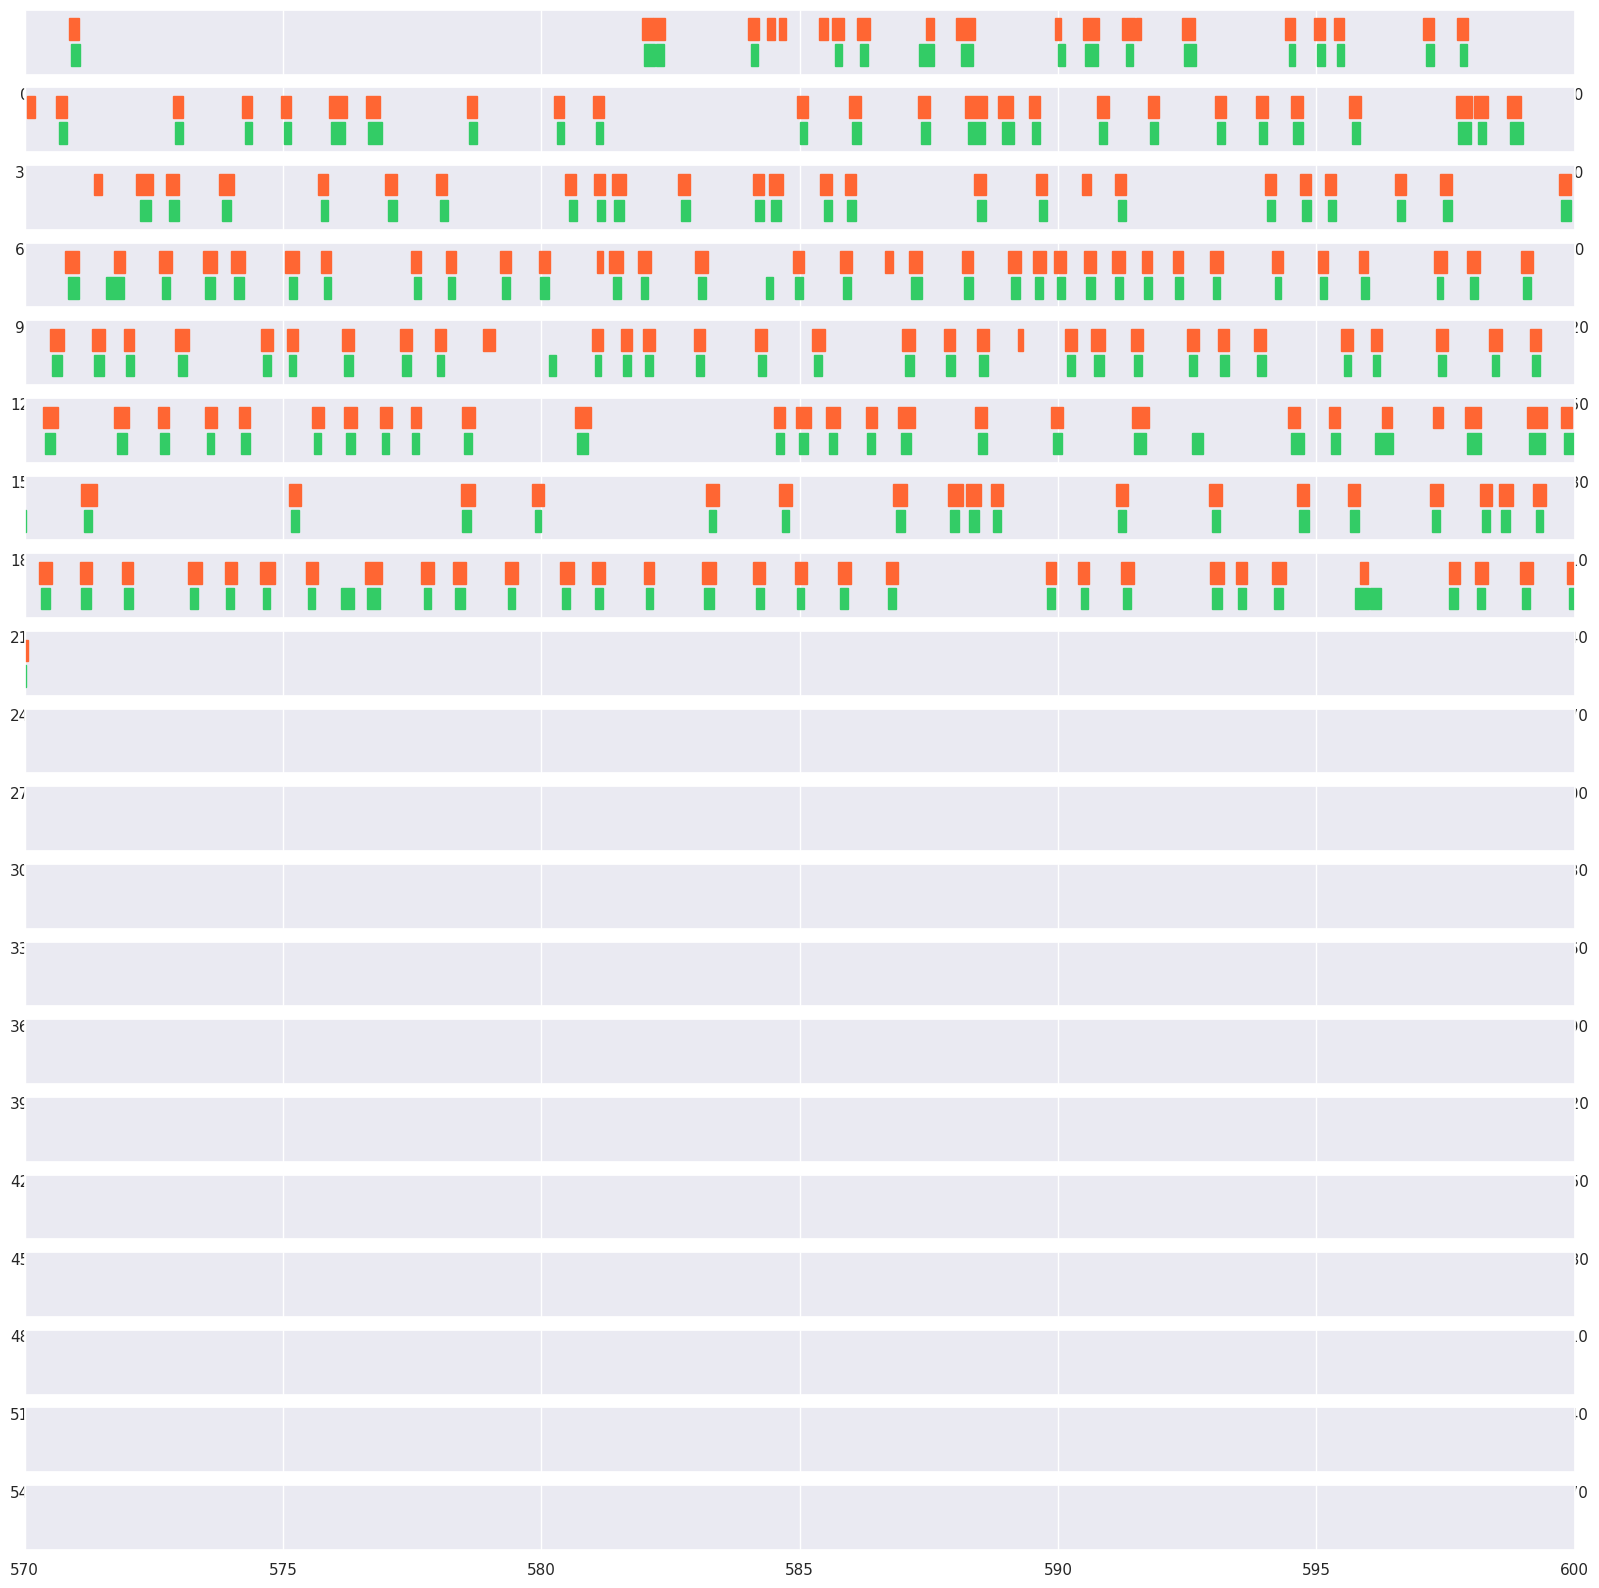

In [274]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib.patches import Rectangle

def render_event_array(ax, blink_on_idx, blink_off_idx, y, color):
    # flags = np.ones(len(legend_labels))
    legends = {}

    for i in range(len(blink_on_idx)):
        start = blink_on_idx[i]/200
        end = blink_off_idx[i]/200
        height = 0.5
        patch = Rectangle((start, y), end - start, height, color=color)
        ax.add_patch(patch)
        # legends["blink"] = patch

    ax.set_yticks([])
    ax.set_ylim(0, 1.5)

def create_subplot(ax, on_idx, off_idx, pred_on, pred_off, start, end, colors):
    render_event_array(ax, on_idx, off_idx, 0.2, color=colors[0])
    render_event_array(ax, pred_on, pred_off, 0.8, color=colors[1])
    ax.set_xlim(start, end)


blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
blink_off_idx = np.where(np.isin(ts, blink_ts))[0]

predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])
predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

f, ax = plt.subplots(20, 1)
f.set_size_inches(20, 20)

colors = [[0.2, 0.8, 0.4], [1, 0.4, 0.2]]
time_intervals = [(i * 30, (i + 1) * 30) for i in range(20)]

for i, (start, end) in enumerate(time_intervals):
    create_subplot(ax[i], blink_on_idx, blink_off_idx, predicted_blink_on, predicted_blink_off, start, end, colors)


In [82]:
from label_mapper import label_mapping
from src.utils import resize_images
from src.post_processing import smooth_array, smooth_proba, classify


# Load each blink event
def get_confidence(start_idx, end_idx, smoothed_proba):
    """ Compute confidence for a blink event

    Parameters
    ----------
    start_idx : int
        Index of the start of the blink event
    end_idx : int
        Index of the end of the blink event
    proba : array
        Array of shape (n_samples, n_classes) containing the output of the classifier
    pp_params : dict
        Dictionary containing the parameters of the post-processing
    """

    tmp_proba = smoothed_proba[start_idx:end_idx, :]

    transition_on_off = np.where(tmp_proba[:,2] >= tmp_proba[:,1])[0][0]
   
    confidence_onset = np.mean(tmp_proba[:transition_on_off, 1])
    confidence_offset = np.mean(tmp_proba[transition_on_off:, 2])
    confidence_blink = (confidence_onset + confidence_offset)/2

    return confidence_blink, confidence_onset, confidence_offset

def find_ts_index(ts, t):
    """ Find index of a timestamp in a list of timestamps

    Parameters
    ----------
    ts : array
        Array of timestamps
    t : float
        Timestamp to find
    """
    
    return np.where(ts == t)[0][0]

def get_blink_events(iclip):
    """ Load a recording and return the timestamps, images and blink events
    
    Returns
    -------
    ts : array
    
    """

    of_params, pp_params = get_params()
    aug_params = AugParams()
    of_params.n_layers = 5
    of_params.layer_interval = 7
    of_params.grid_size = 4
    of_params.window_size = 15

    clf = get_classifier("/users/tom/git/neon_blink_detection/weights/xgb.sav")

    rec = video_loader(of_params, aug_params)
    ts, images_left, images_right = rec._get_frames_pyav(clip_names[iclip], 
    convert_to_gray=True)

    t = rec._get_timestamps(clip_names[iclip])
    times = (ts - t[0]) / 1e9

    blink_df = rec._load_gt_labels(clip_names[iclip])

    grid = create_grids(of_params.img_shape, of_params.grid_size+2, full_grid=False)
    images_left, images_right = resize_images(images_left, images_right, of_params.img_shape)

    feature_array, _ = calculate_optical_flow(of_params, images_left, images_right, grids=grid)

    features = concatenate_features(feature_array, of_params)
    proba = clf.predict_proba(features)
    blink_events = post_process(ts, proba, pp_params)


    left_images, right_images = resize_images(
        images_left, images_right, img_shape=(64, 64)
    )

    blink_ts = blink_df[blink_df["label"]=="onset"]["start_ts"]
    blink_on_idx = np.where(np.isin(ts, blink_ts))[0]
    blink_ts = blink_df[blink_df["label"]=="offset"]["end_ts"]
    blink_off_idx = np.where(np.isin(ts, blink_ts))[0]
    
    predicted_blink_on = np.array([np.where(np.isin(ts, blink_events[x].start_time))[0][0] for x in range(len(blink_events))])

    predicted_blink_off = np.array([np.where(np.isin(ts, blink_events[x].end_time))[0][0] for x in range(len(blink_events))])

    pred = [(predicted_blink_on[x], predicted_blink_off[x]) for x in range(len(predicted_blink_on))]

    gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

    return pred, gt, proba, left_images, right_images, times



In [104]:
data_dict = {}

for iclip in range(len(clip_names)):
    print("Processing clip {}".format(iclip))

    clip_data = {
        'confidence_blink_fp': [],
        'confidence_probas_tp': [],
        'confidence_probas_fp': [],
        'confidence_blink_tp': [],
        'confidence_li_fp': [],
        'confidence_ri_fp': [],
        'confidence_li_tp': [],
        'confidence_ri_tp': [],
        'true_positives': [],
        'false_positives': [],
    }

    pred_blink, gt_blinks, proba, li, ri, times = get_blink_events(iclip)
    smoothed_proba = smooth_proba(proba, pp_params)
    iou_results, true_positives, false_negatives, false_positives = compute_multiple_iou(gt_blinks, pred_blink)

    clip_data['true_positives'] = [(true_positives[x][0], tuple(times[np.array(true_positives[x][1])])) for x in range(len(true_positives))]

    clip_data['false_positives'] = [(false_positives[x][0], tuple(times[np.array(false_positives[x][1])])) for x in range(len(false_positives))]


    print("Number of false positives: {}".format(len(false_positives)))

    for i in range(len(true_positives)):
        start_idx = true_positives[i][1][0]
        end_idx = true_positives[i][1][1]
        confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = get_confidence(start_idx, end_idx, smoothed_proba)
        clip_data['confidence_blink_tp'].append(confidence_blink_tmp)
        clip_data['confidence_probas_tp'].append(smoothed_proba[start_idx:end_idx, :])  
        clip_data['confidence_li_tp'].append(li[start_idx:end_idx, :, :])
        clip_data['confidence_ri_tp'].append(ri[start_idx:end_idx, :, :])

    for i in range(len(false_positives)):
        start_idx = false_positives[i][1][0]
        end_idx = false_positives[i][1][1]
        confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = get_confidence(start_idx, end_idx, smoothed_proba)
        clip_data['confidence_blink_fp'].append(confidence_blink_tmp)
        clip_data['confidence_probas_fp'].append(smoothed_proba[start_idx:end_idx, :])
        clip_data['confidence_li_fp'].append(li[start_idx:end_idx, :, :])
        clip_data['confidence_ri_fp'].append(ri[start_idx:end_idx, :, :])

    data_dict[clip_names[iclip]] = clip_data

Processing clip 0
Number of false positives: 12
Processing clip 1


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 3
Processing clip 2


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 21
Processing clip 3
Number of false positives: 2
Processing clip 4
Number of false positives: 4
Processing clip 5


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 8
Processing clip 6


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 0
Processing clip 7


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 7
Processing clip 8


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Number of false positives: 2


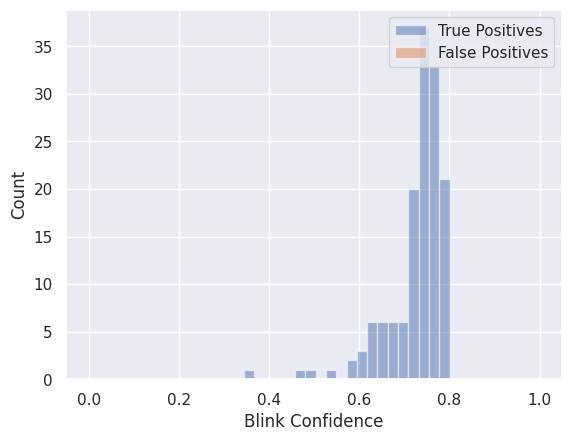

In [95]:
import matplotlib.pyplot as plt
# same as above, but normalize the two histograms to the same area
fig, ax = plt.subplots(1, 1)
ax.hist(confidence_blink, bins=20, alpha=0.5, label="True Positives", density=False)
ax.hist(confidence_blink_fp, bins=20, alpha=0.5, label="False Positives", density=False)
ax.set_xlabel("Blink Confidence")
ax.set_ylabel("Count")
ax.legend(loc="upper right")
# ax.set_ylim(0, 10)

**CREATE VIDEO SHOWING CONFIDENCE AND PROBABILITIES**

In [111]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns
iclip = 7

confidence_blink = np.array(data_dict[clip_names[iclip]]['confidence_blink_tp'])
confidence_blink_sorted_idx = np.argsort(confidence_blink)

index = confidence_blink_sorted_idx[1]
print(index)

fig, axs = plt.subplots(2, 2)

video_left = data_dict[clip_names[iclip]]["confidence_li_tp"][index]
video_right = data_dict[clip_names[iclip]]["confidence_ri_tp"][index]

fig.set_size_inches(8, 6)
im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
axs[0, 0].axis("off")
axs[0, 1].axis("off")

plt.close() # this is required to not display the generated image

# plot proba output of the classifier for the false positive event
axs[1, 0].plot(data_dict[clip_names[iclip]]['confidence_probas_tp'][index])
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlabel("Frame")
axs[1, 0].set_ylabel("Probability")
# legend
axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")
sns.set()

# Create a vertical line object
vline = axs[1, 0].axvline(x=0, color=[0.5, 0.5, 0.5], linestyle=':')

axs[1, 1].text(0.5, 0.5, "Blink Confidence: %.2f" %(confidence_blink[index]), fontsize=14, ha='center')
axs[1, 1].text(0.5, 0.3, "Start: %.2f" %(data_dict[clip_names[iclip]]['true_positives'][index][0]), fontsize=12, ha='center')
# add clip name
axs[1, 1].text(0.5, 0.2, "Clip: %s" %(clip_names[iclip]), fontsize=12, ha='center')

axs[1, 1].axis("off")

def init():
    im0.set_data(video_left[0,:,:])
    im1.set_data(video_right[0,:,:])
    vline.set_xdata(0)

def animate(frame):
    im0.set_data(video_left[frame,:,:])
    im1.set_data(video_right[frame,:,:])
    vline.set_xdata(frame) # Update the vertical line position

    return im0, im1, vline

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

anim.save('/users/tom/blink_videos/false_positive_example_%.2f.mp4' %(confidence_blink[index]), extra_args=['-vcodec', 'libx264'])

HTML(anim.to_html5_video())


11


In [65]:
im2 = axs[1, 0].plot(data_dict[clip_names[iclip]]['confidence_probas_tp'][index])


In [66]:
im2 = axs[0 ,0].imshow(video_left[0, :, :], cmap='gray')